In [17]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import imageio
from scipy import interpolate
from skimage.filters import gaussian
plt.style.use(['science', 'notebook'])
import tomopy
import functions

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.measure import profile_line

In [18]:
As = [functions.normalize_phantom(imageio.imread(f'images/phantom{i}.png').sum(axis=2)) \
      for i in range(1,5)]

In [19]:
cmin = np.array(As).min()
cmax = np.array(As).max()

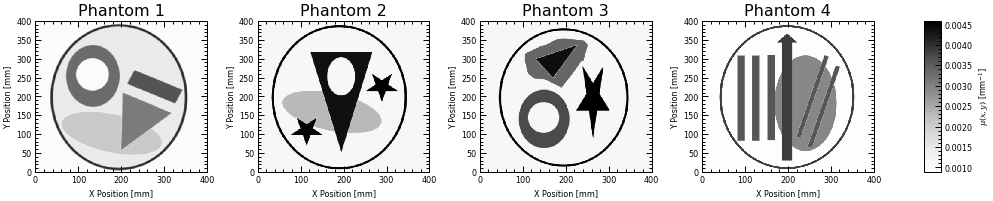

In [20]:
fig, ax = plt.subplots(1,5,figsize=(14,3), gridspec_kw={'width_ratios':[1,1,1,1,0.1]})
ax[0].pcolor(As[0], cmap='Greys', vmin=cmin, vmax=cmax)
ax[1].pcolor(As[1], cmap='Greys', vmin=cmin, vmax=cmax)
ax[2].pcolor(As[2], cmap='Greys', vmin=cmin, vmax=cmax)
im = ax[3].pcolor(As[3], cmap='Greys', vmin=cmin, vmax=cmax)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax[:-1]]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax[:-1]]
plt.colorbar(im, cax=ax[4])
ax[4].set_ylabel('$\mu(x,y)$ [mm$^{-1}$]', fontsize=8)
ax[0].set_title('Phantom 1')
ax[1].set_title('Phantom 2')
ax[2].set_title('Phantom 3')
ax[3].set_title('Phantom 4')
fig.tight_layout()
plt.savefig('images/phantoms.png', dpi=200)
plt.show()

In [21]:
Ts = np.array([np.asarray(imageio.imread(f'images/t{i}.png').sum(axis=2) > 0) for i in range(1,24)])
T = Ts.sum(axis=0).astype(bool)            

In [22]:
A_norm = functions.normalize_phantom(As[1])

In [23]:
U = functions.get_tumour_dist(T, sigma=3)

In [24]:
PET_og, dpoints, dangles = functions.get_original_PET(U, T, lam=500)

In [25]:
prob_of_detections = functions.compute_prob_of_detections(A_norm, dpoints, dangles, n=A_norm.shape[0])

In [26]:
PET_att, mask_att = functions.get_attenuated_PET(dpoints, dangles, prob_of_detections, n=400)

In [27]:
PET_att

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

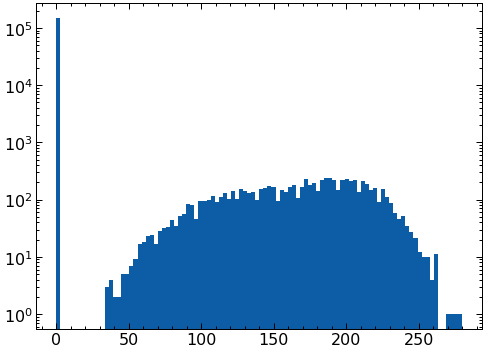

In [28]:
plt.hist(PET_att.ravel(), bins=100)
plt.semilogy()
plt.show()

In [29]:
PET_og[PET_og>0].min()

69.0

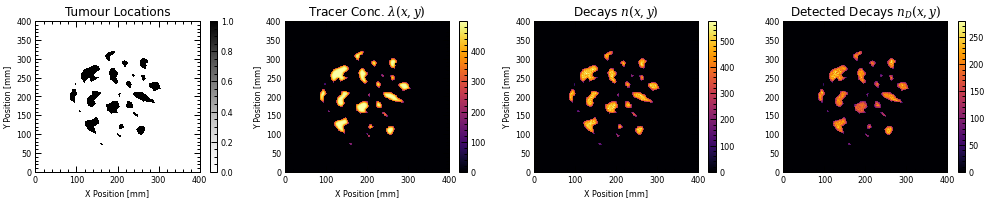

In [34]:
fig, ax = plt.subplots(1,4,figsize=(14,3))
im = ax[0].pcolor(T, cmap='Greys')
c = plt.colorbar(im, ax=ax[0])
c.ax.tick_params(axis='y', labelsize=8)
ax[0].set_title('Tumour Locations', fontsize=12)
im = ax[1].pcolor(500*U, cmap='inferno')
c = plt.colorbar(im, ax=ax[1])
c.ax.tick_params(axis='y', labelsize=8)
ax[1].set_title('Tracer Conc. $\lambda(x,y)$', fontsize=12)
im = ax[2].pcolor(PET_og, cmap='inferno')
c = plt.colorbar(im, ax=ax[2])
c.ax.tick_params(axis='y', labelsize=8)
ax[2].set_title('Decays $n(x,y)$', fontsize=12)
im = ax[3].pcolor(PET_att, cmap='inferno')
c = plt.colorbar(im, ax=ax[3])
c.ax.tick_params(axis='y', labelsize=8)
ax[3].set_title('Detected Decays $n_D(x,y)$', fontsize=12)
[a.tick_params(axis='x', labelsize=8) for a in ax]
[a.tick_params(axis='y', labelsize=8) for a in ax]
[a.set_xlabel('X Position [mm]', fontsize=8) for a in ax[:-1]]
[a.set_ylabel('Y Position [mm]', fontsize=8) for a in ax[:-1]]
fig.tight_layout()
plt.savefig('images/tumours.png', dpi=200)
plt.show()

Sinogram

In [31]:
sino_att, rs, thetas =  functions.get_sinogram(dpoints, dangles, mask=mask_att)
sino, rs, thetas =  functions.get_sinogram(dpoints, dangles)

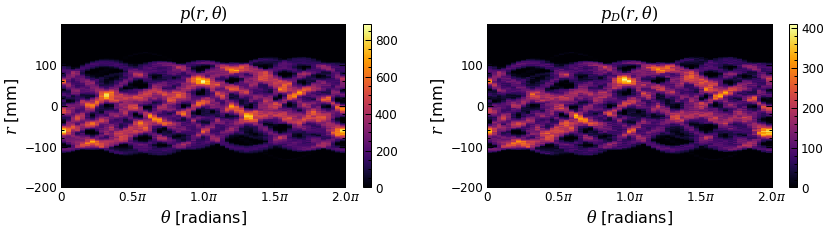

In [32]:
fig, axes = plt.subplots(1,2,figsize=(14,3))
ax = axes[1]
im = ax.pcolor(thetas, rs, sino_att, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$p_D(r,\theta)$')
ax = axes[0]
im = ax.pcolor(thetas, rs, sino, cmap='inferno')
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.1f}$\pi$'.format(val/np.pi) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
ax.set_xlabel(r'$\theta$ [radians]')
ax.set_ylabel('$r$ [mm]')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(axis='y', labelsize=12)
ax.set_title(r'$p(r,\theta)$')
plt.savefig('images/sinos.png', dpi=200)
plt.show()